In [1014]:
%env CUDA_VISIBLE_DEVICES=0
import torch
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import math

env: CUDA_VISIBLE_DEVICES=0


# Set up Cuda

In [1015]:
CUDA = torch.cuda.is_available()
#CUDA = False
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")

True


# Define functions to generate and check learning parameters

In [1016]:
#Given desired output length, filter length, latent input length, and stride - check if the params are valid
def check_params(out_len, filt_len, in_len, stride):
    n_true = (in_len - 1)*stride + filt_len
    f_true = out_len - (in_len - 1)*stride
    k_true = (out_len - filt_len)/stride + 1
    s_true = (out_len - filt_len)/(in_len - 1)
    
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return False
    
    if(out_len != n_true or filt_len != f_true or in_len != k_true or not k_true.is_integer() or not s_true.is_integer()):
        return False
    
    return True

#get stride given three other parameters; returns -1 if input is an invalid combo
def get_s(out_len, filt_len, in_len):
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(in_len, int))):
        return -1
    
    stride = (out_len - filt_len)/(in_len - 1)
    
    if(not stride.is_integer()):
        return -1
    
    return int(stride)

#get latent input length given three other parameters; returns -1 if input is an invalid combo
def get_k(out_len, filt_len, stride):
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(stride, int))):
        return -1
    
    in_len = (out_len - filt_len)/stride + 1
    
    if(not in_len.is_integer()):
        return -1
    
    return int(in_len)

#get filter length given three other parameters; returns -1 if input is an invalid combo
def get_f(out_len, in_len, stride):
    if(not (isinstance(out_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return -1
    
    filt_len = out_len - (in_len - 1)*stride
    
    return filt_len

#get output length given three other parameters; returns -1 if input is an invalid combo
def get_n(filt_len, in_len, stride):
    if(not (isinstance(filt_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return -1
    
    out_len = (in_len - 1)*stride + filt_len
    
    return out_len

# Define functions to generate the weight vector and Data matrix

In [1017]:
#generate a weight vector made by concatenating nc vectors of length f vertically, initiliazed with N(0,1) weights
def gen_weights(f, nc, cuda):
    weights = torch.zeros((f*nc))
    #weights.data.normal_(0, 1)*(1/math.sqrt(f*nc))
    
    if(cuda):
        weights = weights.cuda()
    
    return weights

#generate a single strided block of latent input - contains k N(0,1) entries with (s-1) zeros between each entry
def gen_z_block(k, s, cuda):
    z = torch.zeros(k)
    z.data.normal_(0, 1)*(1/math.sqrt(k))
    
    if(cuda):
        z = z.cuda()

    z_strided = torch.zeros((k - 1)*s + 1)

    if(cuda):
        z_strided = z_strided.cuda()

    inds = [i*s for i in range(k)]

    z_strided[inds] = z
    
    return z_strided

#generate a (n,f) latent input matrix for one channel - contains a strided z block shifted down one row in each column 
def gen_z_mat(n, f, k, s, cuda):
    z_block = gen_z_block(k, s, cuda)
    block_len = list(z_block.shape)[0]
    
    z_mat = torch.zeros((n, f))
    
    if(cuda):
        z_mat = z_mat.cuda()
    
    for i in range(f):
        z_mat[i:block_len + i, i] = z_block
        
    return z_mat

#generate a Z matrix used as Data in linear regression, made by concatenating nc latent input matrices horizontally 
def gen_z_data(n, f, k, s, nc, cuda):
    z_latent = torch.zeros((n, f*nc))
    
    if(cuda):
        z_latent = z_latent.cuda()
    
    for i in range(nc):
        z_latent[:, i*f:i*f+f] = gen_z_mat(n, f, k, s, cuda)
    
    return z_latent

# Define gradient functions for normal linear regression and inverse problem

In [1018]:
def get_gradient(y, Z, w):
    return torch.matmul(Z.t(), y) - torch.matmul(torch.matmul(Z.t(), Z), w)

def get_gradient_inverse(y, Z, w, A):
    AZ = torch.matmul(A, Z)
    AZw = torch.matmul(AZ, w)
    ZTAT = torch.matmul(Z.t(), A.t())
    
    return torch.matmul(ZTAT, (AZw - y))

# Define Gradient Descent

In [1019]:
#given target signal y, data Z, weights w, stepsize, and number of iterations, perform gradient descent for linear regression on w 
#optionally can choose to log the MSE of each iterative solution against a true reference target
def gradient_descent(y, Z, w, stepsize, num_iter, cuda, log_true=False, true_signal=None):
    w_t = w
    if(cuda):
        w_t.cuda()

    mse = torch.nn.MSELoss().type(dtype)
    
    mse_log = torch.zeros((num_iter))
    if(cuda):
        mse_log = mse_log.cuda()
    
    if(log_true):
        mse_log_true = torch.zeros((num_iter))
        if(cuda):
            mse_log_true = mse_log_true.cuda()
    
    for i in range(num_iter):
        w_t = w_t - stepsize*get_gradient(y, Z, w_t)
        
        mse_log[i] = mse(y, torch.matmul(Z, w_t))
    
        if(log_true):
            mse_log_true[i] = mse(true_signal, torch.matmul(Z, w_t))
            
    if(log_true):
        return (w_t, mse_log, mse_log_true)
    
    return (w_t, mse_log)

In [1020]:
#given target signal y, data Z, weights w, stepsize, and number of iterations, perform gradient descent for linear regression on w 
#optionally can choose to log the MSE of each iterative solution against a true reference target
def gradient_descent_inverse(y, Z, w, A, stepsize, num_iter, cuda, tossed_samples):
    w_t = w
    if(cuda):
        w_t.cuda()
    
    num_samples = list(A.shape)[0]

    Ay = torch.matmul(A, y)

    mse = torch.nn.MSELoss().type(dtype)
        
    mse_log_true = torch.zeros((num_iter))
    mse_log = torch.zeros((num_iter))
    if(cuda):
        mse_log = mse_log.cuda()
        mse_log_true = mse_log_true.cuda()
    
    for i in range(num_iter):
        w_t = w_t - stepsize*get_gradient_inverse(Ay, Z, w_t, A)
        
        Zw = torch.matmul(Z, w_t)
        
        mse_log[i] = mse(Ay, torch.matmul(A, Zw))
        mse_log_true[i] = mse(y[tossed_samples], Zw[tossed_samples])
            
            
    return (w_t, mse_log, mse_log_true)


In [1021]:
def normalise(y):
    """
    y0 = y.squeeze()
    maxi = np.amax(y0)
    mini = np.amin(y0)
    return 2*(y0 - mini)/(maxi - mini) - 1
    """
    y0 = y.squeeze()
    std = np.std(y0)
    mean = np.mean(y0)
    return (y0 - mean)/std

# Define parameters and check the param generator functions

In [1022]:
#define output len, filter len, input len, and stride
n = 32
f = 8
k = 4
s = 8

nc = 16

num_segments = int((f*nc)/n)

#check if the params are valid - should return true
print(check_params(n,f,k,s))

print(get_n(f,k,s) == n)
print(get_f(n,k,s) == f)
print(get_k(n,f,s) == k)
print(get_s(n,f,k) == s)

print("total params: " + str(f * nc))
print("num segments: " + str(num_segments))

True
True
True
True
True
total params: 128
num segments: 4


# Check the generators and Generate the Z matrix for Linear Regression

In [1023]:
weights = gen_weights(f, nc, CUDA)
Z = gen_z_data(n, f, k, s, nc, CUDA)

# Find Eigenvectors of Data Matrix

In [1024]:
X = torch.zeros((f*nc, f*nc))
if(CUDA):
    X = X.cuda()

Z_split = Z[0:n-8, :]
print(Z_split.shape)
X[:,:] = torch.matmul(Z_split.t(), Z_split)

evals, evecs = torch.eig(X, eigenvectors=True)

#evals is (f*nc,2) with reals on first col and imaginary on second col (evecs[0] = evecs[0,0] + ievecs[0,1])
#evecs is (f*nc,f*nc) with evecs in the columns 
print(evals.shape)
print(evecs.shape)

torch.Size([24, 128])
torch.Size([128, 2])
torch.Size([128, 128])


In [1025]:
#Sort the real eigenvalues in descending order 
sort_inds = torch.sort(evals[:,0], descending=True)[1]

sorted_evecs = torch.zeros((f*nc,f*nc))
if(CUDA):
    sorted_evecs = sorted_evecs.cuda()

#Arrange the columns of the eigenvector matrix to match the sorted order of the eigenvalues
sorted_evecs[0:2, list(range(f*nc))] = evecs[0:2, sort_inds]
sorted_evecs[2:f*nc, list(range(f*nc))] = evecs[2:f*nc, sort_inds]

In [1026]:
#will hold our eigenvectors, segmented into n-dimensional chunks to create num_segments*f*nc new segmented eigenvectors
segmented_evecs = torch.zeros((n, num_segments*f*nc)) 
if(CUDA):
    segmented_evecs = segmented_evecs.cuda()

#Traverse through each n-length chunk of rows of evec, across all (f*nc) columns
#Copy them through across all n rows of segmented_evecs, through each (f*nc)-length chunk of columns 
for i in range(num_segments):
    segmented_evecs[:, i*(f*nc):(i+1)*(f*nc)] = sorted_evecs[i*(n):(i+1)*(n), :] 

print(segmented_evecs.shape)

torch.Size([32, 512])


In [1027]:
all_reals = torch.nonzero(evals[:,1]).squeeze()

if (list(all_reals.shape)[0] != 0):
    print("Complex eigenvalues!")
else:
    print("NO complex eigenvalues!")

Complex eigenvalues!


In [1028]:
"""
for i in range (num_segments):
    plt.figure()
    plt.plot(range(n), segmented_evecs.cpu().numpy()[:, i], marker = '*', linestyle='None')
    plt.show()
"""

"\nfor i in range (num_segments):\n    plt.figure()\n    plt.plot(range(n), segmented_evecs.cpu().numpy()[:, i], marker = '*', linestyle='None')\n    plt.show()\n"

# Plot eigenvectors with largest eigenvalues

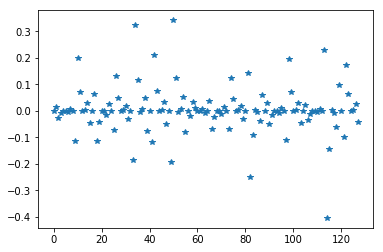

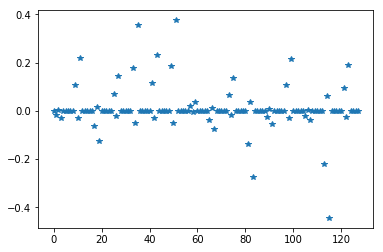

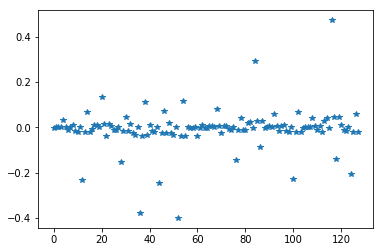

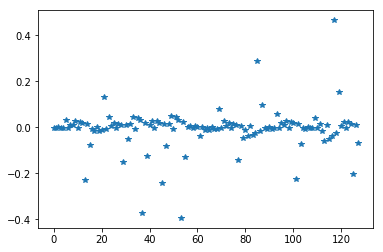

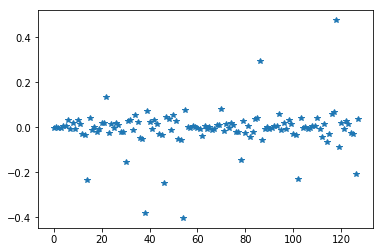

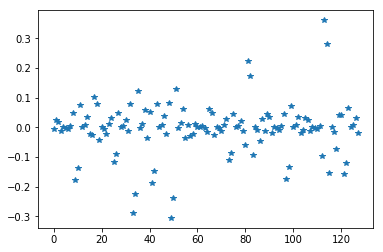

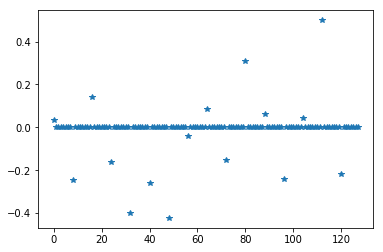

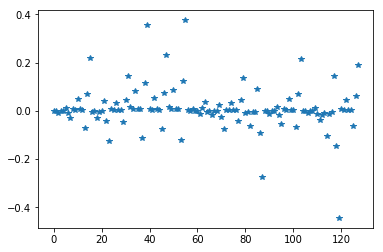

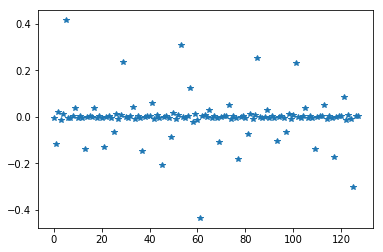

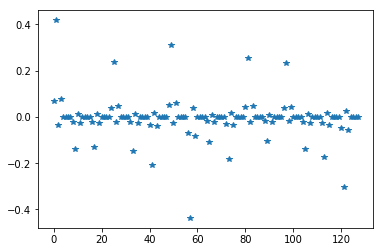

In [1029]:
for i in range(10):
    plt.figure()
    plt.plot(range(f*nc), sorted_evecs.cpu().numpy()[:,i], marker = '*', linestyle="none")
    plt.show()

# Plot last few rows of Z

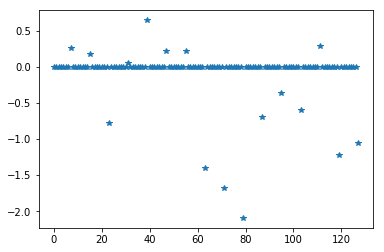

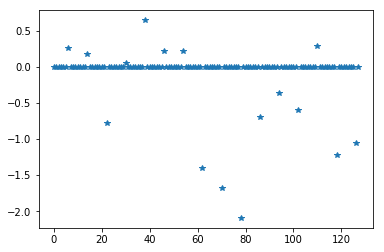

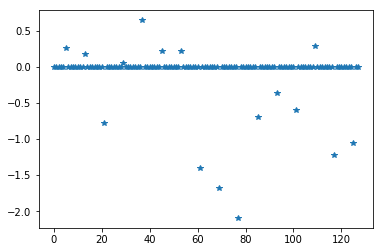

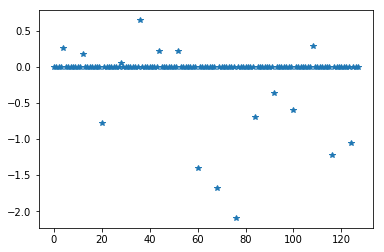

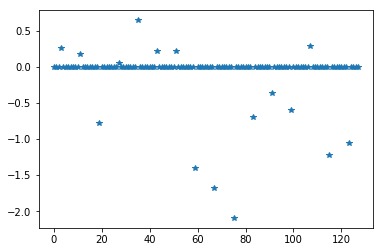

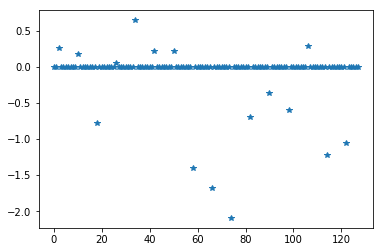

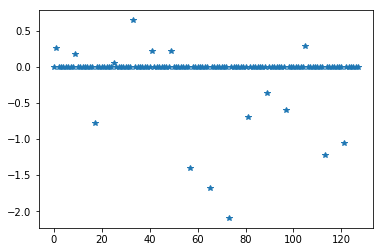

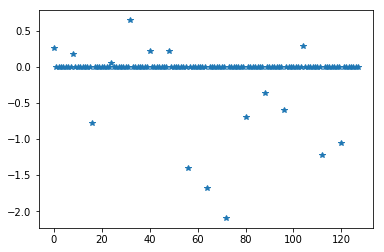

In [1030]:
for i in range(8):
    plt.figure()
    plt.plot(range(f*nc), Z[n-i-1,:].cpu().numpy(), marker = '*', linestyle="none")
    plt.show()

# Find the weights for the eigenvector-of-Z'Z basis representation of the rows of Z

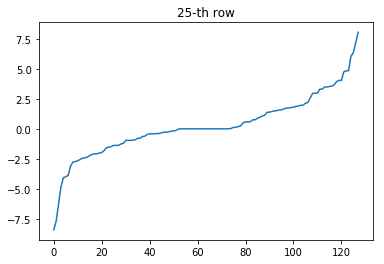

tensor(0.6390, device='cuda:0')


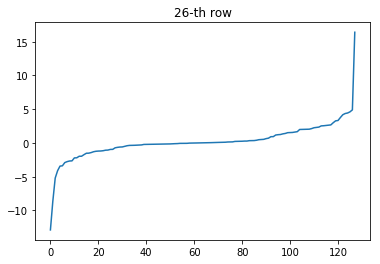

tensor(0.6503, device='cuda:0')


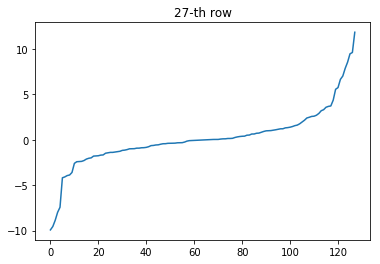

tensor(0.6379, device='cuda:0')


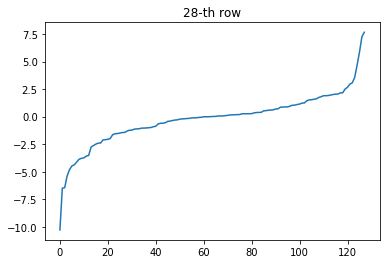

tensor(0.7733, device='cuda:0')


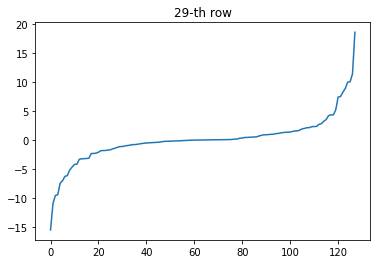

tensor(0.6681, device='cuda:0')


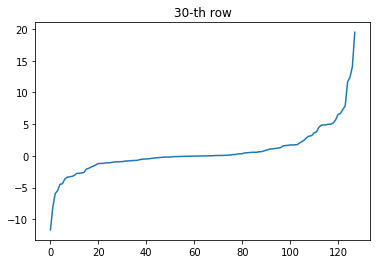

tensor(0.4837, device='cuda:0')


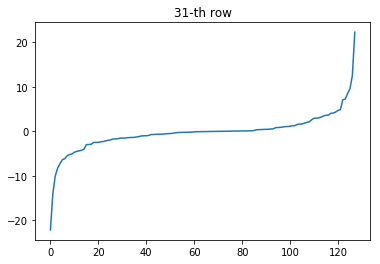

tensor(0.7222, device='cuda:0')


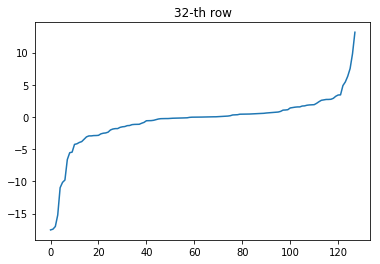

tensor(0.8691, device='cuda:0')


In [1031]:
Z_split_in = torch.inverse(sorted_evecs)
if(CUDA):
    Z_split_in = Z_split_in.cuda()

for i in range(8):
    evec_basis_weights = torch.matmul(Z_split_in, Z[n-8+i,:])

    basis_w = torch.sort(evec_basis_weights)[0]
    if(CUDA):
        basis_w = basis_w.cuda()

    plt.figure()
    plt.plot(range(f*nc), basis_w.cpu().numpy())
    plt.title(str(i+25) + "-th row")
    plt.show()

    print(torch.norm(basis_w[0:int(f*nc/4)])/torch.norm(basis_w))

# Create Target

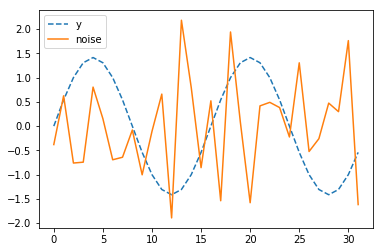

In [1032]:
X_OUTPUT = np.arange(n)

#y0 = np.ones(n)
y0 = np.sin(2 *2*np.pi *X_OUTPUT / n) + 1
#y0 = sorted_evecs[0:n,0].cpu().numpy().squeeze() + sorted_evecs[n:n*2,0].cpu().numpy().squeeze() 
     #+ sorted_evecs[n*2:n*3,0].cpu().numpy().squeeze() + sorted_evecs[n*3:n*4,0].cpu().numpy().squeeze()
y0_noisy = 0.05 * np.random.randn(n)

y0 = normalise(y0)
y0_noisy = normalise(y0_noisy)

y = torch.tensor(y0).type(dtype)
y_noisy = torch.tensor(y0_noisy).type(dtype)

if(CUDA):
    y = y.cuda()
    y_noisy = y_noisy.cuda()

plt.figure()
plt.plot(range(n), y0, label='y', linestyle="dashed")
plt.plot(range(n), y0_noisy, label='noise')
plt.legend()
plt.show()

# Perform Linear Regression

In [1033]:
stepsize = 1e-4
NUM_ITER = 1000
NUM_RUNS = 5

kept_samples = 24
tossed_samples = list(range(kept_samples,n))

A = torch.eye(n)[list(range(kept_samples)), :]
if(CUDA):
    A = A.cuda()

mse_log = torch.zeros(NUM_ITER)
mse_log_true = torch.zeros(NUM_ITER)
if(CUDA):
    mse_log = mse_log.cuda()
    mse_log_true = mse_log_true.cuda()

for i in range(NUM_RUNS):
        
    weights = gen_weights(f, nc, CUDA)
    
    weights, log, log_true = gradient_descent_inverse(y, Z, weights, A, stepsize, NUM_ITER, CUDA, tossed_samples)
    
    mse_log += log
    mse_log_true += log_true

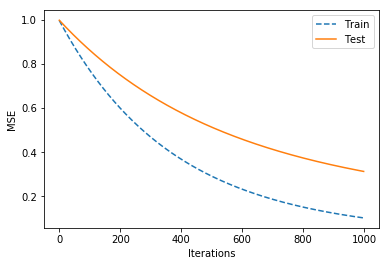

In [1034]:
plt.figure()
plt.plot(range(NUM_ITER), mse_log.cpu().numpy()/NUM_RUNS, label='Train', linestyle = "dashed")
plt.plot(range(NUM_ITER), mse_log_true.cpu().numpy()/NUM_RUNS, label='Test')
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Iterations")
plt.show()

In [1035]:
mse_log_noise = torch.zeros(NUM_ITER)
mse_log_true_noise = torch.zeros(NUM_ITER)
if(CUDA):
    mse_log_noise = mse_log.cuda()
    mse_log_true_noise = mse_log_true.cuda()

for i in range(NUM_RUNS):
        
    weights_noisy = gen_weights(f, nc, CUDA)
    
    weights_noisy, log, log_true = gradient_descent_inverse(y_noisy, Z, weights_noisy, A, stepsize, NUM_ITER, CUDA, tossed_samples)
    
    mse_log_noise += log
    mse_log_true_noise += log_true

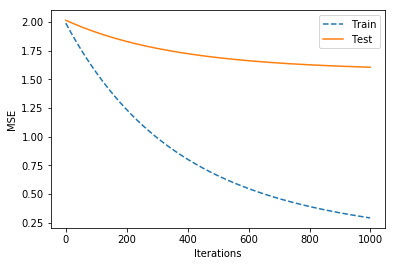

In [1036]:
plt.figure()
plt.plot(range(NUM_ITER), mse_log_noise.cpu().numpy()/NUM_RUNS, label='Train', linestyle = "dashed")
plt.plot(range(NUM_ITER), mse_log_true_noise.cpu().numpy()/NUM_RUNS, label='Test')
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Iterations")
plt.show()

In [1037]:
"""
plt.figure()
plt.plot(range(n), y0, label = 'original')
plt.plot(range(n), torch.matmul(Z, weights).cpu().numpy(), label = 'Predicted')
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Iterations")
plt.show()
"""

'\nplt.figure()\nplt.plot(range(n), y0, label = \'original\')\nplt.plot(range(n), torch.matmul(Z, weights).cpu().numpy(), label = \'Predicted\')\nplt.legend()\nplt.ylabel("MSE")\nplt.xlabel("Iterations")\nplt.show()\n'